## Twitter Sentiment Analysis

In [ ]:
import nltk

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Dataset

In [ ]:
from google.colab import drive

### You can get this file from the link: https://nlp.stanford.edu/projects/glove/
### Unzip it and upload any of the 50/ 100/ 200/ 300 dimensional .txt file on your drive
# Note the file path to point to your downloaded/ uploaded GloVe file

drive.mount('/content/drive')
glove_file_path = '/content/drive/MyDrive/NLP CODES June 2025/Session 5/'   ### For COLAB

df = pd.read_csv(glove_file_path + 'training.1600000.processed.noemoticon.csv',
                 delimiter=',', encoding='ISO-8859-1')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1048567,4,1960186342,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Madelinedugganx,My GrandMa is making Dinenr with my Mum
1048568,4,1960186409,Fri May 29 07:33:43 PDT 2009,NO_QUERY,OffRoad_Dude,Mid-morning snack time... A bowl of cheese noo...
1048569,4,1960186429,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Falchion,@ShaDeLa same here say it like from the Termi...
1048570,4,1960186445,Fri May 29 07:33:44 PDT 2009,NO_QUERY,jonasobsessedx,@DestinyHope92 im great thaanks wbuu?


In [ ]:
df.columns = ['Sentiment','id','date','query','user','text']
df.head()

,Sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
df = df[['Sentiment','text']]

In [ ]:
df.columns

Index(['Sentiment', 'text'], dtype='object')

In [ ]:
df.Sentiment.value_counts()

,count
Sentiment,
0,799996
4,248576


In [ ]:
df['Sentiment'] = df['Sentiment'].replace({4:1})
df.Sentiment.value_counts()

,count
Sentiment,
0,799996
1,248576


* 0 represent Negative sentiment
* 1 represents Positive sentiment

In [ ]:
df.isna().sum()

,0
Sentiment,0
text,0


**Inference: The data is unbalanced therfore we will downsample the data to have same count for each sentiment**

*italicized text*## Downsampling the dataset

In [ ]:
from sklearn.utils import resample

In [ ]:
## majority class 0
df_majority = df[df['Sentiment']==0]
## minority class 1
df_minority = df[df['Sentiment']==1]

In [ ]:
df_minority.shape

(248576, 2)

In [ ]:
# downsample the majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,
                                 n_samples=len(df_minority),
                                 random_state=1234)

In [ ]:
frames = [df_majority_downsampled, df_minority]

df = pd.concat(frames)
df.head()

,Sentiment,text
74567,0,Wow slept for almost 12hours. Sleepy me!! Uni ...
668722,0,gets bored with an idea too easily ... like tw...
286706,0,To my girls - sorry i've been a homebody latel...
632911,0,BK once again for the weekend...If it wasnt fo...
356735,0,@DonnieWahlberg Now why didn't you do that las...


In [ ]:
df.Sentiment.value_counts()

,count
Sentiment,
0,248576
1,248576


[link text](https://)## Data Preprocessing

1. removing stop words
2. removing punctuations
3. Stemmer
4. removing tags
5. removing special characters
6. lowercase conversion

In [ ]:
## remove stopwords and punctuation marks
nltk.download('stopwords')
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()

corpus = df['text'].tolist()
print(len(corpus))
print(corpus[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...


497152
Wow slept for almost 12hours. Sleepy me!! Uni now, boo! I wanna stay home, drink tea and watch house... 


[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('wordnet')
# %%time
final_corpus = []
final_corpus_joined = []
for i in df.index:

    text = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    #Convert to lowercase
    text = text.lower()
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)

    ##Convert to list from string
    text = text.split()

    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text
            if not word in stuff_to_be_removed]
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

[nltk_data] Downloading package wordnet to /root/nltk_data...


#### Storing the cleaned data seperately

In [ ]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["Sentiment"] = df["Sentiment"].values

In [ ]:
data_cleaned['Sentiment'].value_counts()

,count
Sentiment,
0,248576
1,248576


In [ ]:
data_cleaned.head()

,text,Sentiment
0,wow slept almost hour sleepy uni boo wanna sta...,0
1,get bored idea easily like twitter,0
2,girl sorry homebody lately dont feel well does...,0
3,bk weekend wasnt puppy stay as,0
4,donniewahlberg last night atlanta,0


## EDA

In [ ]:
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['Sentiment'] = df["Sentiment"].values
data_eda.head()

,text,Sentiment
0,"[wow, slept, almost, hour, sleepy, uni, boo, w...",0
1,"[get, bored, idea, easily, like, twitter]",0
2,"[girl, sorry, homebody, lately, dont, feel, we...",0
3,"[bk, weekend, wasnt, puppy, stay, as]",0
4,"[donniewahlberg, last, night, atlanta]",0


In [ ]:
# Storing positive data seperately
positive = data_eda[data_eda['Sentiment'] == 1]
positive_list = positive['text'].tolist()

# Storing negative data seperately

negative = data_eda[data_eda['Sentiment'] == 0]
negative_list = negative['text'].tolist()

In [ ]:
positive_all = " ".join([word for sent in positive_list for word in sent ])
negative_all = " ".join([word for sent in negative_list for word in sent ])

#### Word Cloud Positive data

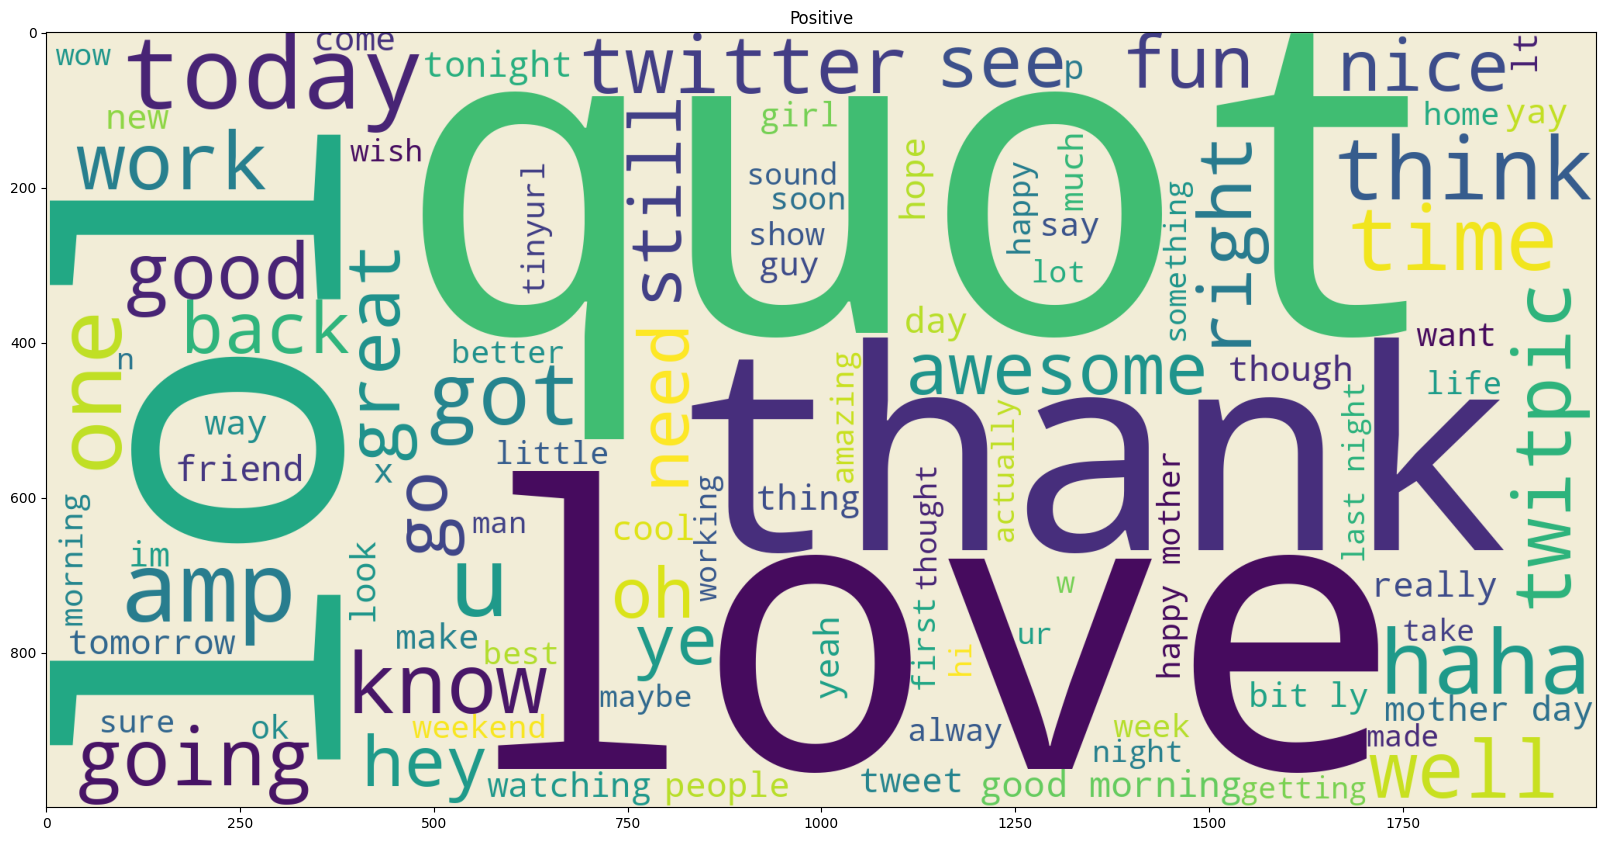

In [ ]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(positive_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

#### Word CLoud Negative data

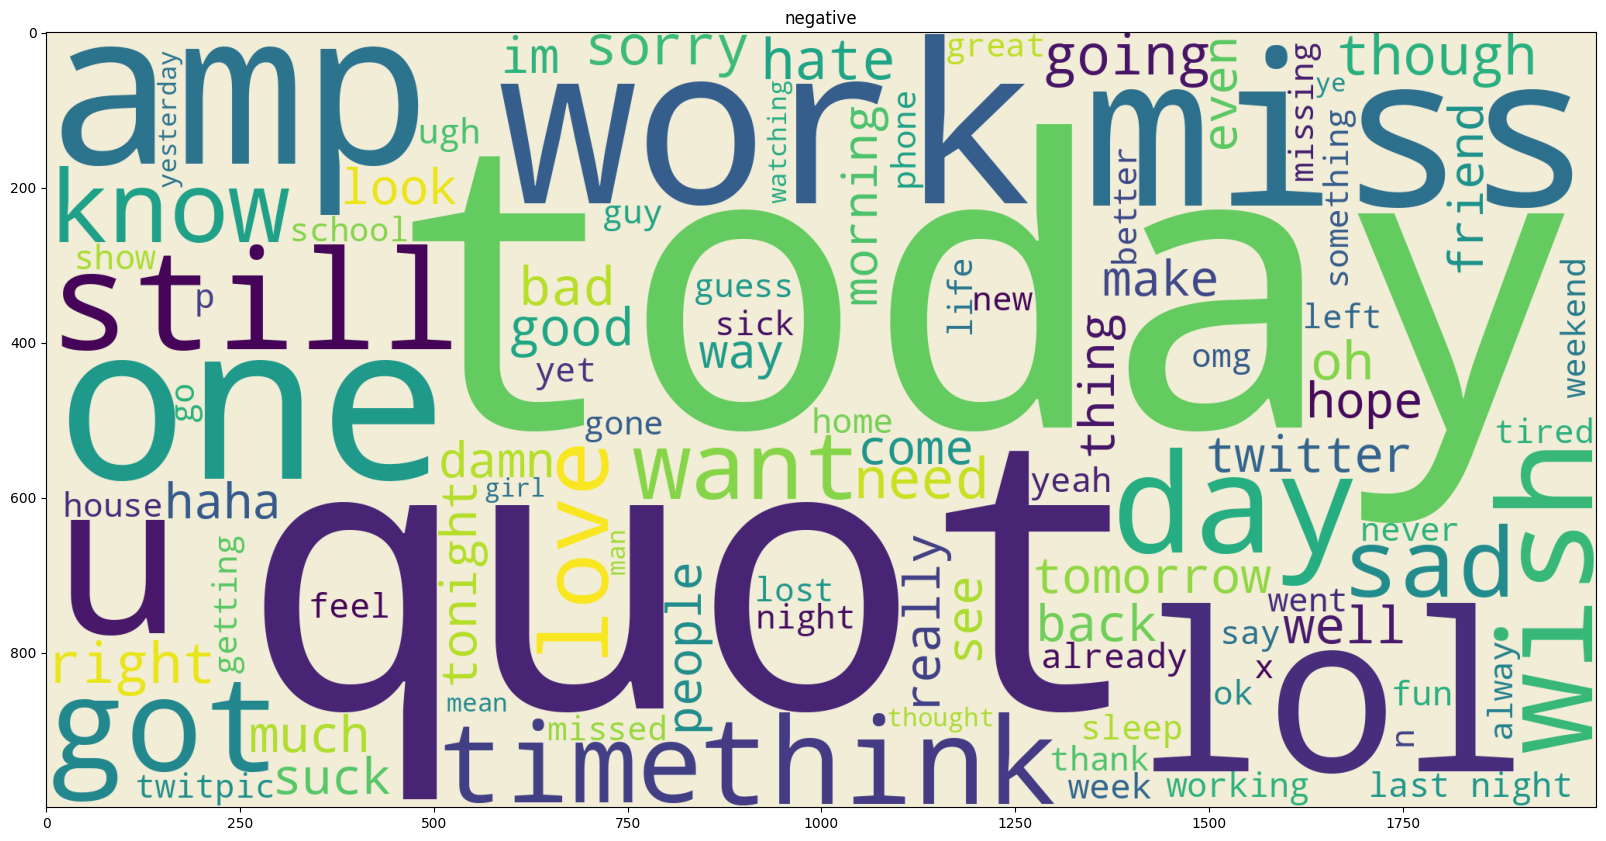

In [ ]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='#F2EDD7FF',
                      max_words = 100).generate(negative_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("negative")
plt.show()

**Inference:**
* Positive data has words like Thank, love , LOL, Haha ets
* Negative data has words like work, sad, tired, suck sorry <br>
Some of the words are still common in both such as Lol, quot

#### One word count

In [ ]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1

    return(dic)
count_corpus = get_count(positive_list)

In [ ]:
# count_corpus

{'love': 14969,
 'health': 139,
 'uandpets': 6,
 'u': 12448,
 'guy': 3475,
 'r': 1829,
 'best': 3431,
 'im': 6434,
 'meeting': 662,
 'one': 8907,
 'besties': 40,
 'tonight': 3642,
 'cant': 1515,
 'wait': 4036,
 'girl': 2891,
 'talk': 1287,
 'darealsunisakim': 3,
 'thanks': 11375,
 'twitter': 7193,
 'add': 770,
 'sunisa': 1,
 'got': 8267,
 'meet': 1108,
 'hin': 5,
 'show': 2898,
 'dc': 143,
 'area': 193,
 'sweetheart': 105,
 'sick': 486,
 'really': 5887,
 'cheap': 146,
 'hurt': 370,
 'much': 5265,
 'eat': 1078,
 'real': 1229,
 'food': 1170,
 'plus': 392,
 'friend': 4308,
 'make': 5340,
 'soup': 177,
 'lovesbrooklyn': 2,
 'effect': 131,
 'everyone': 3105,
 'productoffear': 1,
 'tell': 1916,
 'burst': 24,
 'laughing': 254,
 'loud': 172,
 'making': 1353,
 'come': 4094,
 'sulk': 5,
 'keith': 40,
 'hill': 279,
 'thans': 1,
 'response': 141,
 'ihad': 3,
 'already': 1667,
 'find': 1614,
 'answer': 402,
 'keepinupwkris': 14,
 'jealous': 354,
 'hope': 6486,
 'great': 8328,
 'time': 10718,
 'vega

In [ ]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

In [ ]:
count_corpus

,word,count
485,good,20273
84,day,19789
0,love,14969
181,http,14800
196,quot,14567
...,...,...
170962,lpm,1
170963,teaforlife,1
170964,stormmmo,1
170965,schoolioo,1


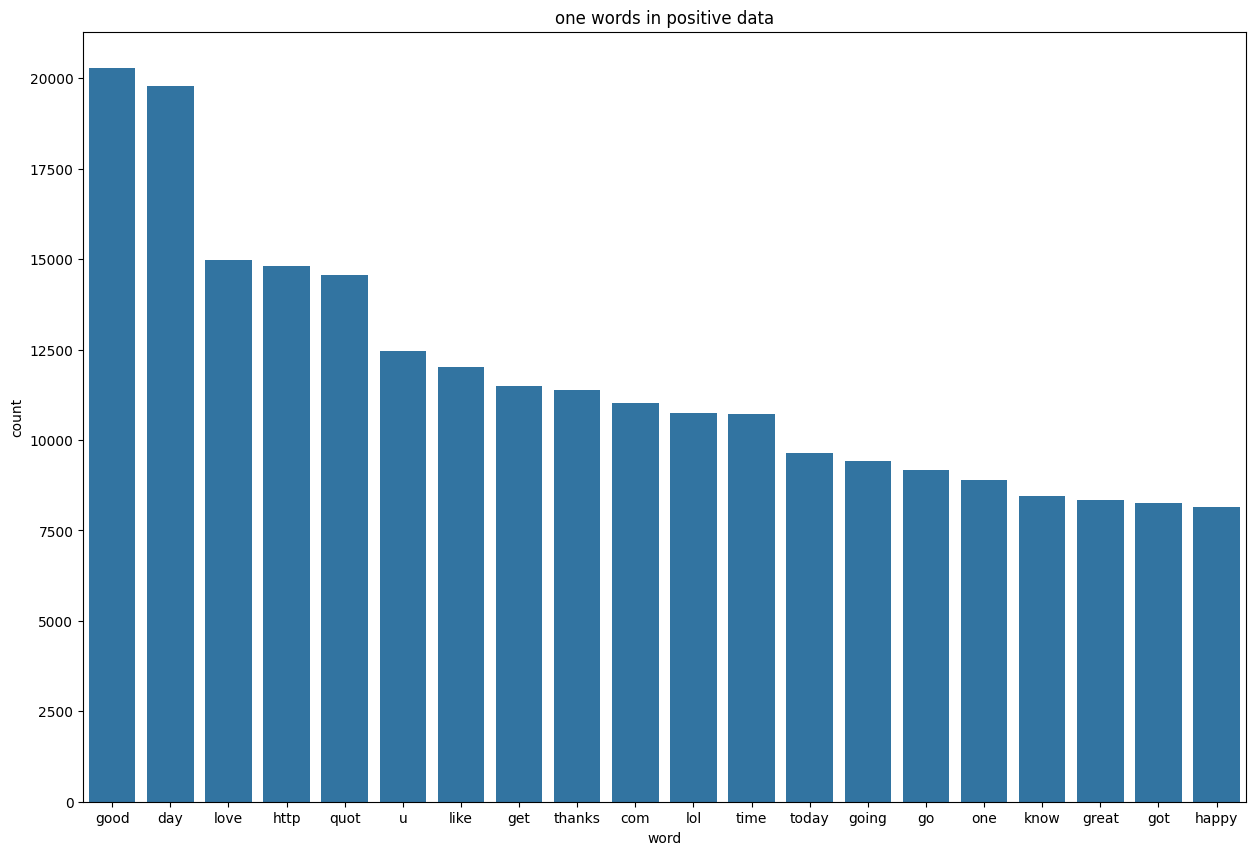

In [ ]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('one words in positive data')
plt.show()

In [ ]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1

    #dic = dict(sorted(dic.items() , key = lambda x:x[1],reverse=True))
    return(dic)
count_corpus = get_count(negative_list)

In [ ]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

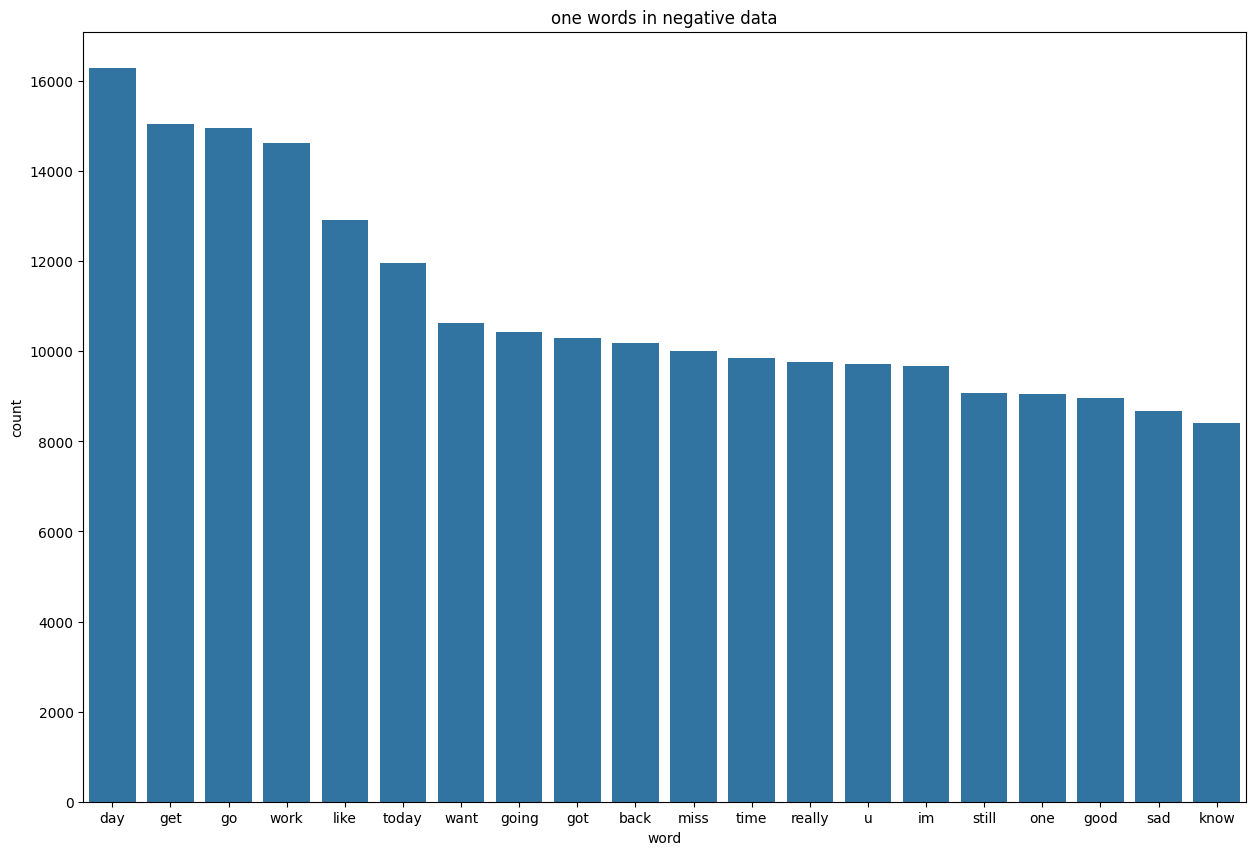

In [ ]:
import seaborn as sns
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.title('one words in negative data')
plt.show()

**Inference**
* Positive data has words like good, day, thanks, great, happy
* Negative data has words like work, miss, sad etc

## Classification
### Naive bayes for sentiment analysis

In [ ]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_list)
negative_tokens_for_model = get_tweets_for_model(negative_list)

In [ ]:
positive_tokens_for_model

<generator object get_tweets_for_model at 0x7e140dead7e0>

In [ ]:
import random

positive_dataset = [(review_dict, "Positive")
                     for review_dict in positive_tokens_for_model]

negative_dataset = [(review_dict, "Negative")
                     for review_dict in negative_tokens_for_model]
dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:333091]
test_data = dataset[333091:]


In [ ]:
train_data[1]

({'got': True,
  'phone': True,
  'call': True,
  'ex': True,
  'boyfriend': True,
  'weird': True,
  'even': True,
  'think': True,
  'right': True,
  'ugh': True,
  'night': True,
  'much': True,
  'love': True},
 'Negative')

In [ ]:
# dataset


[({'mayorsam': True,
   'tgeisler': True,
   'thank': True,
   'followfriday': True,
   'great': True,
   'day': True},
  'Positive'),
 ({'got': True,
   'phone': True,
   'call': True,
   'ex': True,
   'boyfriend': True,
   'weird': True,
   'even': True,
   'think': True,
   'right': True,
   'ugh': True,
   'night': True,
   'much': True,
   'love': True},
  'Negative'),
 ({'found': True, 'interesting': True, 'project': True, 'rac': True},
  'Positive'),
 ({'annagabbert': True,
   'sound': True,
   'preachery': True,
   'anything': True,
   'iphone': True,
   'amazing': True,
   'issue': True,
   'since': True,
   'firmware': True,
   'wink': True},
  'Positive'),
 ({'got': True,
   'cupcake': True,
   'taste': True,
   'good': True,
   'especially': True,
   'screen': True,
   'keyboard': True},
  'Positive'),
 ({'oppcashley': True, 'funnnnn': True}, 'Positive'),
 ({'babyblueonline': True,
   'omg': True,
   'sorry': True,
   'hear': True,
   'really': True,
   'need': True,
   't

In [ ]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print(" Training Accuracy is:", round(classify.accuracy(classifier, train_data),2)*100)

print("Testing Accuracy is:", round(classify.accuracy(classifier, test_data),2)*100)

print(classifier.show_most_informative_features(10))

 Training Accuracy is: 86.0
Testing Accuracy is: 77.0
Most Informative Features
                    iran = True           Negati : Positi =     93.8 : 1.0
                 fawcett = True           Negati : Positi =     49.7 : 1.0
                 unhappy = True           Negati : Positi =     39.0 : 1.0
             squarespace = True           Negati : Positi =     36.4 : 1.0
                hotwords = True           Positi : Negati =     35.0 : 1.0
             heartbroken = True           Negati : Positi =     34.4 : 1.0
                  booooo = True           Negati : Positi =     30.4 : 1.0
            followfriday = True           Positi : Negati =     29.0 : 1.0
                  farrah = True           Negati : Positi =     27.9 : 1.0
              devastated = True           Negati : Positi =     27.7 : 1.0
None


### TFIDF for sentiment analysis

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(data_cleaned['text'])
y = data_cleaned['Sentiment']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify = y)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression

In [ ]:
def metrics(y_train,y_train_pred,y_test,y_test_pred):
  print("training accuracy = ",round(accuracy_score(y_train,y_train_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize = 'all')
  print(classification_report(y_train,y_train_pred))
  plt.show()

  print("testing accuracy = ",round(accuracy_score(y_test,y_test_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred,normalize = 'all')
  print(classification_report(y_test,y_test_pred))
  plt.show()

### Multinomial NB

training accuracy =  85.0
              precision    recall  f1-score   support

           0       0.83      0.88      0.85    166545
           1       0.87      0.82      0.85    166546

    accuracy                           0.85    333091
   macro avg       0.85      0.85      0.85    333091
weighted avg       0.85      0.85      0.85    333091



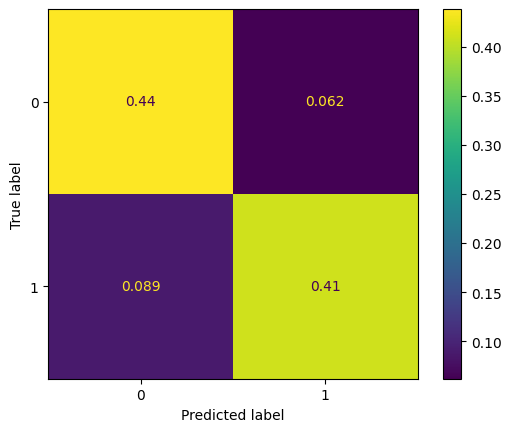

testing accuracy =  76.0
              precision    recall  f1-score   support

           0       0.75      0.80      0.77     82031
           1       0.78      0.73      0.75     82030

    accuracy                           0.76    164061
   macro avg       0.76      0.76      0.76    164061
weighted avg       0.76      0.76      0.76    164061



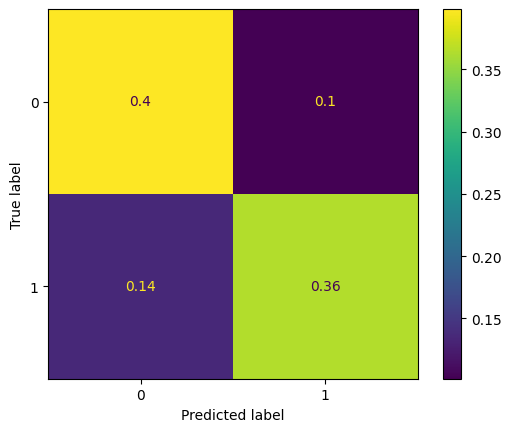

In [ ]:
NB = MultinomialNB()
NB.fit(X_train,y_train)
y_train_pred = NB.predict(X_train)
y_test_pred = NB.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

### Linear SVC

training accuracy =  90.0
              precision    recall  f1-score   support

           0       0.90      0.90      0.90    166545
           1       0.90      0.90      0.90    166546

    accuracy                           0.90    333091
   macro avg       0.90      0.90      0.90    333091
weighted avg       0.90      0.90      0.90    333091



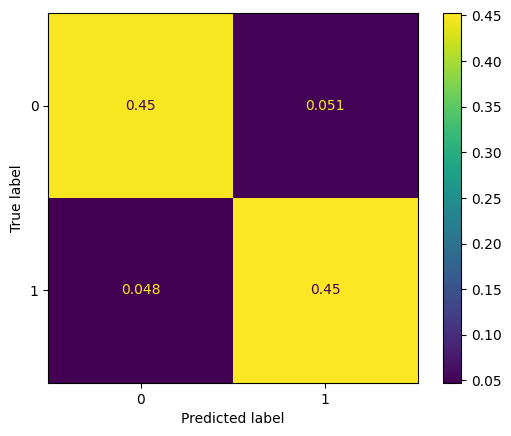

testing accuracy =  77.0
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     82031
           1       0.76      0.78      0.77     82030

    accuracy                           0.77    164061
   macro avg       0.77      0.77      0.77    164061
weighted avg       0.77      0.77      0.77    164061



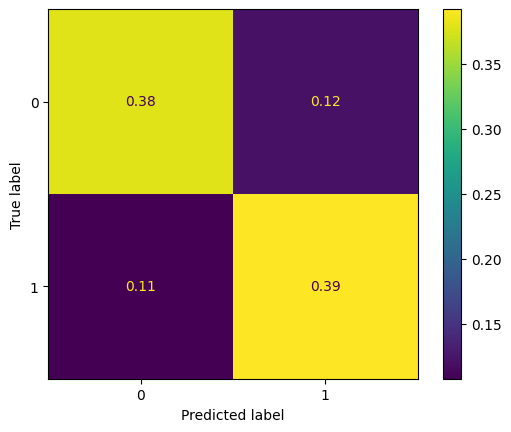

In [ ]:
svc = LinearSVC()
svc.fit(X_train,y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)


### Logistic regression

training accuracy =  82.0
              precision    recall  f1-score   support

           0       0.84      0.81      0.82    166545
           1       0.81      0.84      0.83    166546

    accuracy                           0.82    333091
   macro avg       0.82      0.82      0.82    333091
weighted avg       0.82      0.82      0.82    333091



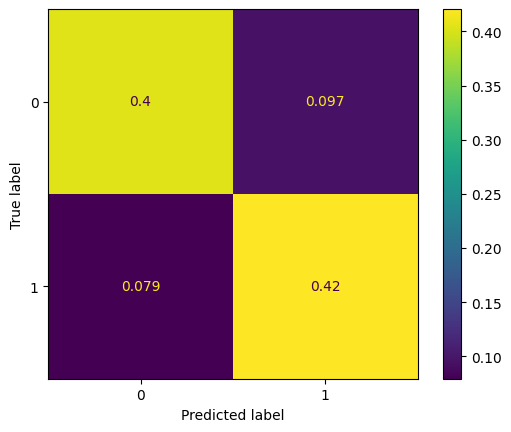

testing accuracy =  78.0
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     82031
           1       0.76      0.80      0.78     82030

    accuracy                           0.78    164061
   macro avg       0.78      0.78      0.78    164061
weighted avg       0.78      0.78      0.78    164061



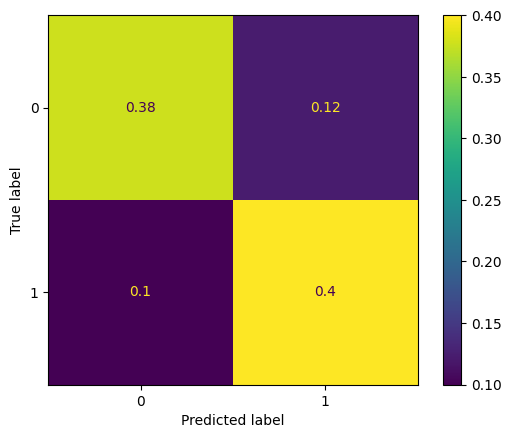

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

## Conclusion

|Model|Training Accuracy|Testing Accuracy|
|---|---|---|
|Naive Bayes|86%|76%|
|Multinomial NB| 85%|76%|
|linear SVC|90%|77%|
|Logistic|83%|78%|




We see that Logistic regression model performs best with least overfitting as compared to other models and has better performance in testing dataset as well